# Hacking the Democratic Debate: Word Clouds in R

Word clouds are an easy way to visualize textual data. They are used to distill text, whether it be a speech, a book, or an article, into a form that shows the frequency of words used. Frequency of a word can be emphasized with size, color or orientation. They are also a great early foray for those looking to get a taste of data science. Making a word cloud requires very little technical know-how. Anyone can make one with a minimal amount of programming ability. 

Today we will go through the entire pipeline of making a word cloud in R. We will start with getting and cleaning our data and then going through all the processing steps to make our final product. To make things interesting, we will use an example from current events; the first Democratic debate, which aired on October 13th from the Wynn Las Vegas in Nevada. Specifically, we will make a word cloud using a transcript of the debate and we will focus on my favorite candidate: Bernie Sanders. We will obtain a copy of the debate transcript in html and parse it to obtain everything that Bernie Sanders said. Then we'll make our wodcloud using the data. 

We begin by loading the packages that we will need into R. The XML package provides functionality to quickly extract content from html. We will use the stringr package to assist with string parsing. The tm package provides functions for parsing text and getting word frequency counts. Finally, the wordcloud package provides an easy interface for making the wordcloud from text.

In [11]:
library(XML)
library(stringr)
library(tm)
library(wordcloud)

In [12]:
setwd('c:/users/troy/dropbox/datascience/demdebate')

First, we will need a transcript. There are several sources of full-text transcripts of the debate. I chose the one published by CBS News, which you can find <a href='http://www.cbsnews.com/news/the-first-democratic-debate-full-rush-transcript/'>here</a>. Next, we download the file to our local drive as so:

In [13]:
download.file('http://www.cbsnews.com/news/the-first-democratic-debate-full-rush-transcript/',
               destfile = 'debatetrans.html')

Once we have the file, we can load it into R as an object of type HTMLInternalDocument, using htmlTreeParse(). This is a special version of the more generic xmlParse() function in the XML library. It is particularly well-suited for html, which may be malformed and does not always conform strictly to xml formatting.  This stores our html document in a tree-like format that makes parsing it a snap.

In [14]:
htmldoc <- htmlTreeParse('debatetrans.html', useInternal=TRUE)

We can take a peek at the html document to get an idea of how to proceed. Looking at the html where the transcript starts, we can see that all of the actual debate speech is wrapped in html 'p' tags, which denote paragraphs. So, a good start would be to extract all of the text that resides within the p tags. Again, the XML library makes this very easy. We use the xpathApply function, which is a specialized version of R's apply function. We provide xpathApply three arguments: our HTMLInternalDocument object that we want to parse, a node type to extract (all p tags in this case), and a function that we wish to perform on each node. The double forward-slash in front of p indicates that we want the p tags from all the nodes of the document. We pass the xmlValue function, which tells xpathApply that we simply want the raw text between each set of p tags. We then unlist() the results. The xpathApply function returns a list, but we prefer to have our results as a character vector. 

In [15]:
htmltext <- unlist(xpathApply(htmldoc, '//p', xmlValue))

The results are now in a character vector, where each element of the vector is the text that resided within each p tag. This is the entire transcript of the debate; however we only want Bernie Sanders' speech. If you take a look at htmltext, you will notice a common structure that we can exploit. In each element, if a new speaker is speaking, the text begins with the speaker's name in capital letter followed by a colon. If the element does not represent a new speaker, then the element doest not contain the speaker's name. Also notice that the first time a candidate speaks, the name before the colon is the candidate's full name and title. After that, only the last name is given prior to the colon. 

We first initialize an empty vector named sanders. This will hold all of the sanders quotes that we extract. We then iterate over every element of htmltext and use regexpr() to get the index of the colon, if there is one. If there is no colon, regexpr() returns a -1. If there is a colon, we set the value of the speaker variable to whatever is in front of the colon, and then append everything after the colon to our sanders vector if Sanders is the speaker. If there is no colon and Sanders is still the speaker, then we append the entire quote to our vector. Since the first p tag contains only metadata, and is not part of the transcript, we start with the second element. 

In [16]:
names <- c('SANDERS', 'SEN. BERNARD SANDERS, I-VT.')

sanders <- c()

for (quote in htmltext[2:length(htmltext)]) {
    
    colon <- regexpr(':', quote)[1]
    
    if (colon != -1) {
        speaker <- substring(quote, 1, colon-1)
        if (speaker %in% names) {
            sanders <- append(sanders, substring(quote, colon+1, nchar(quote)))
        }
        
    } else {
        if (speaker %in% names) {
            sanders <- append(sanders, quote)
        }
    }
}
 


Great! Now we have a vector containing all of Bernie Sanders' speech from the debate. Now we are ready to clean it up a bit and get our word frequency counts, so that we can make the cloud. We'll begin this part by turning our vector of strings into a character vector of length 1 using paste. This collapses everything into a single string separated by spaces. 

In [17]:
sanders_corpus <- paste(sanders, collapse=' ')

In order to further process our text data we will use the tm package, which is short for 'text-mining'. Here we turn our character vector into a Corpus object, using VectorSource function to load our sanders_corpus vector. A Corpus object is a collection of text documents. In our case, the Corpus will be a single document. 

In [18]:
sanders_corpus <- Corpus(VectorSource(sanders_corpus))

Now we can use the tm_map function. This allows us to apply transformations to the documents in our Corpus. We call tm_map and pass it two arguments. The first is our Corpus object and the second is a function that is applied to each document. Here we do this five times. Each function that we pass to tm_map should be fairly self-explanatory. We first remove all the white space, punctuation, and numbers. We also remove common SMART stop words using removeWords and passing it the built-in list of common SMART stop words. SMART stop words are a list built by Gerald Salton and Chris Buckley at Cornell University. You can see the entire list and read more about the SMART information retrieval system <a href='http://www.lextek.com/manuals/onix/stopwords2.html'>here</a>. I also removed  all occurrences of "CROSSTALK" which occurred when more than one person was speaking at once, "LAUGHTER", and "APPLAUSE." 

In [19]:
sanders_corpus <- tm_map(sanders_corpus, stripWhitespace)
sanders_corpus <- tm_map(sanders_corpus, removePunctuation)
sanders_corpus <- tm_map(sanders_corpus, removeNumbers)
sanders_corpus <- tm_map(sanders_corpus, removeWords, c('CROSSTALK', 'APPLAUSE', 'LAUGHTER'))
sanders_corpus <- tm_map(sanders_corpus, removeWords, stopwords('SMART'))

We arrive arrive at the final step. The wordcloud() function does most of the work for us here. We pass it a number of arguments that control the appearance of the plot. Scale is the range of the word size. Max.words allows you to set how many of the words in the document are plotted. The rot.per argument determines what proportion of the words you wish to appear vertically. Random.order sets whether or not you want the words to be chosen randomly. We want words to appear by their frequency, so we've set this to false here. If you are following along with this tutorial, feel free to play with the various settings to see how the cloud varies. 

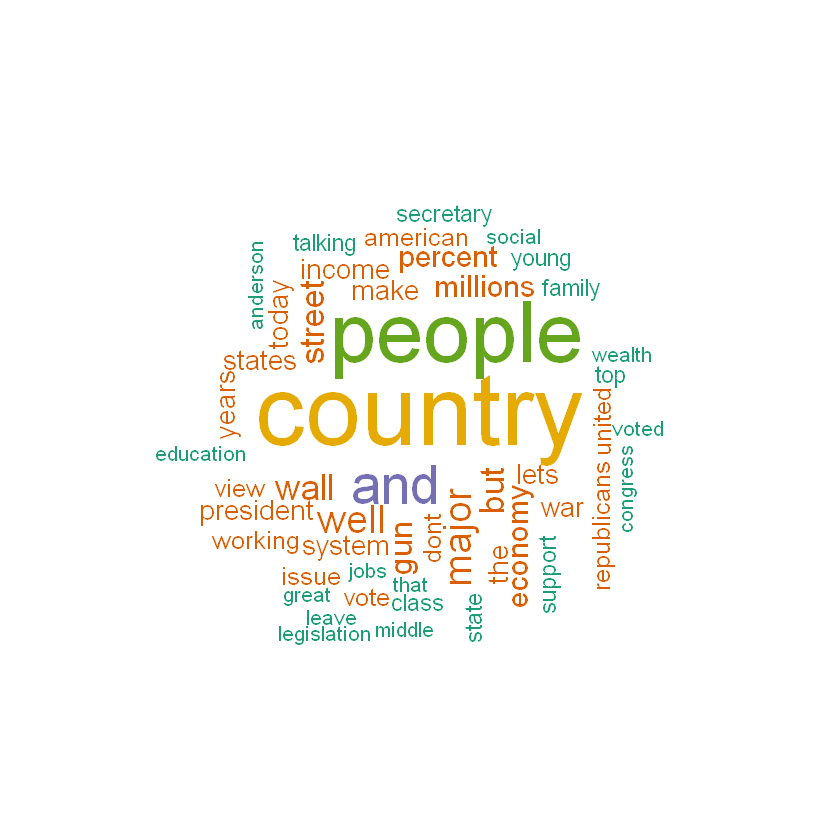

In [20]:
wordcloud(sanders_corpus, 
          scale=c(5,0.5), 
          max.words=50, 
          random.order=FALSE, 
          rot.per=0.35, 
          colors=brewer.pal(6, 'Dark2'))

That's it! We have our finished product. The above code can be easily adapted to create a similar wordcloud for the candidate of your own choosing. You could also apply this approach to one of the Republican or Democratic debates coming up in the near future.  Give it a try and let me know about it in the comments below. Cheers!